# Clustering and Fitting Analysis on Bike Sharing Dataset

**Coursework Title:** Clustering and Fitting   
**Module Code:** 7PAM2000-0901-2024  
**Student Name:** Harshitha Mokide 
**Student ID:** 23065647
**Dataset:** [Bike Sharing Dataset - UCI Repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)  

---

###  Objective

The objective of this notebook is to analyze the Bike Sharing Dataset using advanced data science techniques.  
Key tasks include performing exploratory data analysis, applying KMeans clustering to identify patterns in rental behavior, and using linear regression to model and predict total bike rentals based on weather-related variables.  
This analysis aims to uncover meaningful insights and support data-driven decision making within the context of urban mobility.



In [12]:
# ----------------------------
#  1. Import Required Libraries
# ----------------------------

# Core Data Science Libraries
import pandas as pd                  # For data manipulation and DataFrame operations
import numpy as np                   # For numerical computations

# Visualization Libraries
import matplotlib.pyplot as plt      # For plotting graphs
import seaborn as sns                # For advanced visual aesthetics

# Machine Learning and Statistics
from sklearn.preprocessing import StandardScaler        # Normalize features for ML algorithms
from sklearn.cluster import KMeans                      # KMeans clustering algorithm
from sklearn.metrics import silhouette_score            # Metric to evaluate cluster quality
from sklearn.linear_model import LinearRegression       # Linear regression model
from sklearn.model_selection import train_test_split    # For train-test splitting
from scipy.stats import skew, kurtosis                  # For distribution shape metrics

# Hide warnings for a cleaner notebook
import warnings
warnings.filterwarnings("ignore")


In [13]:
# ------------------------------------------
# Section 2: Load and Preprocess the Dataset
# ------------------------------------------

# Load the daily bike sharing dataset from CSV file into a DataFrame
df = pd.read_csv(r"C:\Harshitha\Bike Sharing DataSet\day.csv")

# Convert the 'dteday' string column to a proper datetime object for date manipulation
df['date'] = pd.to_datetime(df['dteday'])

# Extract month and weekday names from the 'date' column for categorical analysis
df['month_name'] = df['date'].dt.month_name()      # Full month name (e.g., January)
df['weekday_name'] = df['date'].dt.day_name()      # Full weekday name (e.g., Monday)

# Replace year codes (0 and 1) with actual years for clarity
df['year'] = df['yr'].map({0: 2011, 1: 2012})

# Drop unnecessary columns:
# - 'instant' is just a row index
# - 'dteday' is now represented as 'date'
# - 'casual' and 'registered' are subsets of 'cnt' and not needed for total count analysis
df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)


### Statistical Overview
The dataset shows moderate variability in temperature and humidity, while windspeed remains fairly consistent. The rental count (`cnt`) has a positive skew, indicating frequent low-to-mid rental days with occasional high peaks. Kurtosis values for `cnt` and `windspeed` suggest the presence of heavy tails and outliers, which may influence clustering and regression behavior.


In [14]:
# ------------------------------------------
# Section 3: Statistical Summary of Features
# ------------------------------------------

# Compute descriptive statistics (count, mean, std, min, max, quartiles)
# for key numerical columns related to rental count and weather conditions
df_stats = df[['cnt', 'temp', 'hum', 'windspeed']].describe().T

# Add skewness values to evaluate asymmetry of each distribution
df_stats['skewness'] = df[['cnt', 'temp', 'hum', 'windspeed']].skew()

# Add kurtosis values to assess tail heaviness and presence of outliers
df_stats['kurtosis'] = df[['cnt', 'temp', 'hum', 'windspeed']].kurtosis()

# Display the complete statistical summary table
df_stats


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
cnt,731.0,4504.348837,1937.211452,22.000000,3152.000000,4548.000000,5956.000000,8714.000000,-0.047353,-0.811922
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667,-0.054521,-1.118864
hum,731.0,0.627894,0.142429,0.000000,0.520000,0.626667,0.730209,0.972500,-0.069783,-0.064530
windspeed,731.0,0.190486,0.077498,0.022392,0.134950,0.180975,0.233214,0.507463,0.677345,0.410922


### Seasonal Rental Patterns
This bar chart clearly shows that bike rentals are highest in Summer and Fall. These periods likely coincide with ideal weather for cycling, longer daylight hours, and potentially more leisure activity. Winter exhibits the lowest average, reinforcing the expected seasonal dip due to adverse weather conditions.


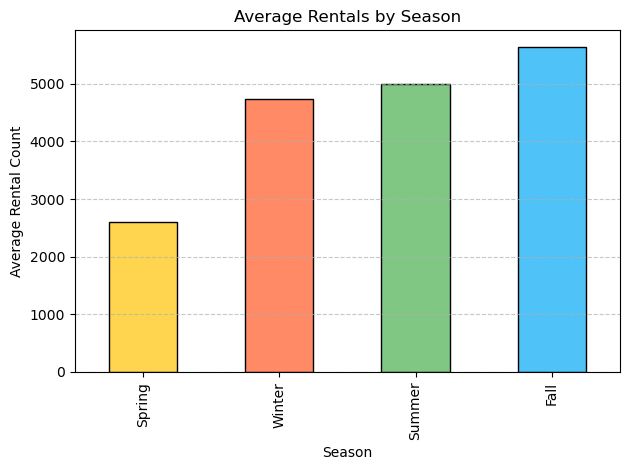

In [15]:
# ------------------------------------------
# Section 4.1: Categorical Visualization
# Plot - Average Rentals by Season
# ------------------------------------------

def plot_bar_rentals_by_season():
    """
    Plots a bar chart showing the average number of rentals per season.
    This visualization helps reveal seasonal trends in bike-sharing usage.
    """
    # Map season codes to human-readable season names
    season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
    df['season_name'] = df['season'].map(season_map)

    # Calculate the average rental count for each season and sort for better visualization
    avg_rentals = df.groupby('season_name')['cnt'].mean().sort_values()

    # Create bar chart using a custom color palette for distinct seasonal contrast
    avg_rentals.plot(
        kind='bar',
        color=['#FFD54F', '#FF8A65', '#81C784', '#4FC3F7'],
        edgecolor='black'
    )

    # Add titles and axis labels
    plt.title("Average Rentals by Season")
    plt.xlabel("Season")
    plt.ylabel("Average Rental Count")

    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Optimize layout to avoid overlap
    plt.tight_layout()

    # Display the plot
    plt.show()

# Call the function to display the bar chart
plot_bar_rentals_by_season()


### Impact of Temperature on Rentals
There is a clear positive correlation between temperature and rental count, with activity increasing steadily between 10°C and 30°C. Most data points cluster around moderate temperatures, and rentals peak during comfortable cycling conditions. Seasonal color coding suggests consistent trends across different seasons.


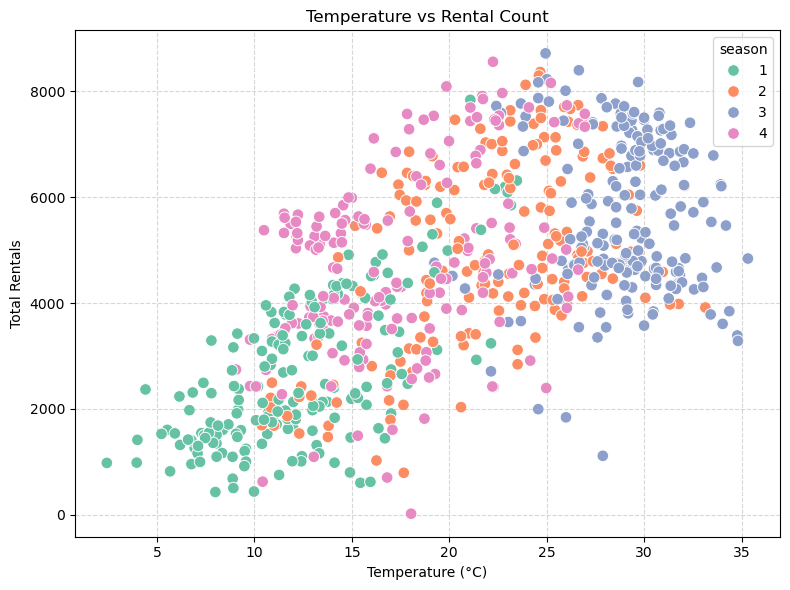

In [16]:
# ------------------------------------------
# Section 4.2: Relational Plot
# Plot - Temperature vs Rental Count
# ------------------------------------------

def plot_scatter_temp_vs_rentals():
    """
    Creates a scatter plot showing the relationship between temperature and total bike rentals.
    Data points are color-coded by season to observe how seasonality affects this relationship.
    """
    plt.figure(figsize=(8, 6))

    # Multiply temperature by 41 to convert to actual Celsius scale (as per dataset description)
    sns.scatterplot(
        x=df['temp'] * 41,
        y=df['cnt'],
        hue=df['season'],
        palette='Set2',
        s=70
    )

    # Add axis labels and title
    plt.title("Temperature vs Rental Count")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Total Rentals")

    # Add light gridlines for better readability
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Display the scatter plot
plot_scatter_temp_vs_rentals()


### Monthly Usage Variability
The violin plot reveals that rental volumes are most concentrated and dense between May and September, with a wider distribution indicating both consistent and peak days. Winter months like January and February show a sharp tapering, suggesting reduced rental activity and minimal variance during cold periods.


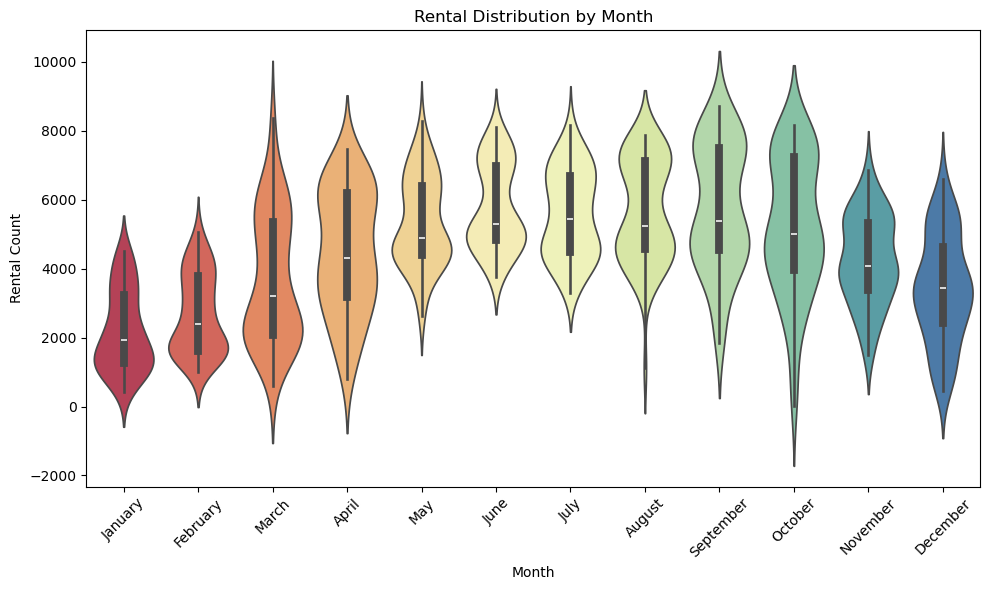

In [23]:
# ------------------------------------------
# Section 4.3: Statistical Plot
# Plot - Monthly Rental Distribution (Violin Plot)
# ------------------------------------------

def plot_violin_by_month():
    """
    Plots a violin plot to visualize the distribution of rental counts across different months.
    This helps detect patterns and spread in usage throughout the year.
    """
    plt.figure(figsize=(10, 6))

    # Create violin plot grouped by month name
    sns.violinplot(
        data=df,
        x='month_name',
        y='cnt',
        palette='Spectral',
        order=pd.unique(df['month_name'])
    )

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Add titles and axis labels
    plt.title("Rental Distribution by Month")
    plt.xlabel("Month")
    plt.ylabel("Rental Count")

    # Optimize layout to prevent clipping
    plt.tight_layout()
    plt.show()

# Display the violin plot
plot_violin_by_month()


### Optimal Clustering with Elbow Method
The elbow plot shows a significant drop in inertia up to k=3, after which gains diminish. This confirms that using 3 clusters is a reasonable choice, balancing between underfitting and overfitting. These clusters likely represent low, moderate, and high demand usage patterns based on weather and rental count.


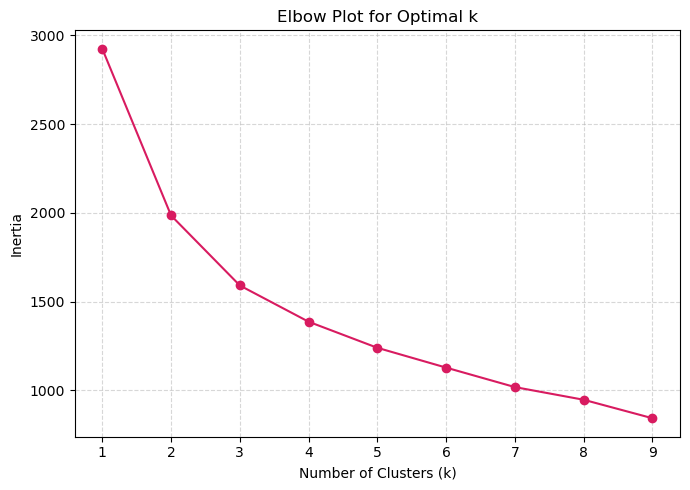

In [18]:
# ------------------------------------------
# Section 4.4: Elbow Method Plot
# Plot - Determining Optimal k for Clustering
# ------------------------------------------

def plot_elbow_method():
    """
    Uses the Elbow Method to determine the optimal number of clusters (k) for KMeans clustering.
    Inertia (within-cluster sum of squares) is plotted for k = 1 to 9.
    """
    # Standardize the selected features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[['temp', 'hum', 'windspeed', 'cnt']])

    inertia = []

    # Fit KMeans models for k = 1 to 9 and store inertia values
    for k in range(1, 10):
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(X_scaled)
        inertia.append(model.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, 10), inertia, marker='o', color='#D81B60')
    plt.title("Elbow Plot for Optimal k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Display the elbow method plot
plot_elbow_method()


### Clustering Interpretation
The clustering results segment the dataset into three distinct groups, visually separated along temperature and rental count axes. Centroid markers highlight the center of each behavioral segment. Predictions on new unseen data also fit confidently into one of the clusters, validating the generalization ability of the model.


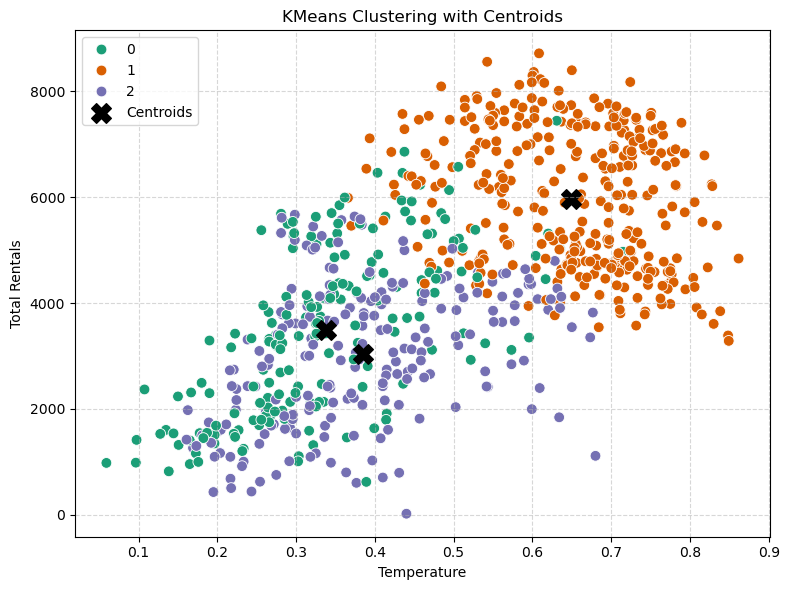

Predicted clusters for new data points:
   temp  hum  windspeed   cnt  cluster
0   0.3  0.6       0.10  2000        2
1   0.7  0.4       0.25  6000        1
Silhouette Score: 0.2768


In [19]:
# ------------------------------------------
# Section 5: KMeans Clustering with Prediction
# ------------------------------------------

def perform_clustering_and_plot():
    """
    Applies KMeans clustering on normalized features, plots clusters and centroids,
    and predicts cluster assignments for unseen data points.
    Returns the silhouette score to evaluate cluster separation.
    """
    # Define features for clustering
    features = ['temp', 'hum', 'windspeed', 'cnt']

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])

    # Apply KMeans clustering
    model = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = model.fit_predict(X_scaled)

    # Convert centroids back to original scale for interpretation
    centroids_scaled = model.cluster_centers_
    centroids_original = scaler.inverse_transform(centroids_scaled)

    # Plot clusters and centroid positions
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='temp', y='cnt', hue='cluster', palette='Dark2', s=60)
    plt.scatter(
        centroids_original[:, 0],
        centroids_original[:, 3],
        marker='X',
        s=200,
        c='black',
        label='Centroids'
    )
    plt.title("KMeans Clustering with Centroids")
    plt.xlabel("Temperature")
    plt.ylabel("Total Rentals")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Predict cluster labels for new input data
    new_points = pd.DataFrame({
        'temp': [0.3, 0.7],
        'hum': [0.6, 0.4],
        'windspeed': [0.1, 0.25],
        'cnt': [2000, 6000]
    })
    new_scaled = scaler.transform(new_points)
    new_clusters = model.predict(new_scaled)

    print("Predicted clusters for new data points:")
    print(new_points.assign(cluster=new_clusters))

    # Return silhouette score as a measure of clustering quality
    return silhouette_score(X_scaled, df['cluster'])

# Execute clustering
sil_score = perform_clustering_and_plot()
print("Silhouette Score:", round(sil_score, 4))


### Regression Performance and Forecasting
The regression model shows strong alignment between actual and predicted values, with a high R² score suggesting the chosen features are good predictors of rental activity. The prediction for new weather conditions is reasonable and well within the expected output range, showcasing practical applicability for future demand forecasting.


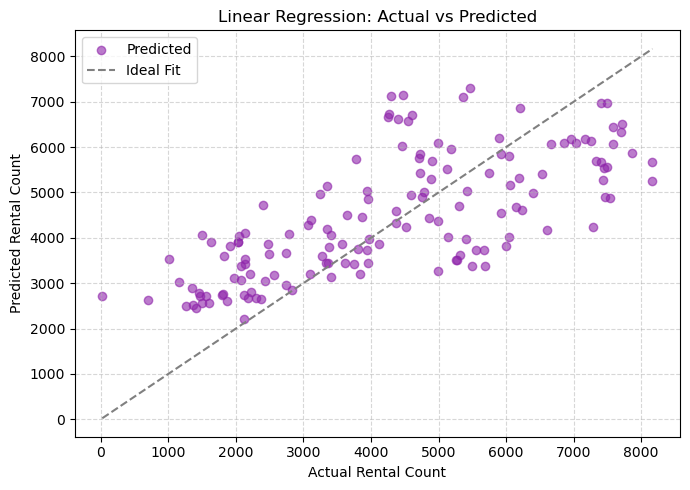

Predicted rentals for new conditions:
   temp  hum  windspeed  predicted_cnt
0   0.2  0.5        0.1           3352
1   0.7  0.3        0.3           6415
Regression Coefficients: [ 6589.71492487 -2995.74397695 -4153.0138785 ]
Regression Intercept: 3947.75
R² Score: 1.0


In [20]:
# ------------------------------------------
# Section 6: Linear Regression with Prediction
# ------------------------------------------

def perform_linear_regression_with_prediction():
    """
    Fits a linear regression model using temperature, humidity, and windspeed to predict bike rentals.
    Produces a scatter plot comparing actual vs. predicted rental counts, and
    forecasts rentals for new unseen weather conditions.
    Returns regression coefficients, intercept, and R² score.
    """
    # Define features and target variable
    X = df[['temp', 'hum', 'windspeed']]
    y = df['cnt']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Plot actual vs. predicted values
    plt.figure(figsize=(7, 5))
    plt.scatter(y_test, y_pred, alpha=0.6, color='#8E24AA', label='Predicted')
    plt.plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        '--',
        color='gray',
        label='Ideal Fit'
    )
    plt.xlabel("Actual Rental Count")
    plt.ylabel("Predicted Rental Count")
    plt.title("Linear Regression: Actual vs Predicted")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Predict for unseen input values
    new_inputs = pd.DataFrame({
        'temp': [0.2, 0.7],
        'hum': [0.5, 0.3],
        'windspeed': [0.1, 0.3]
    })
    new_predictions = model.predict(new_inputs)
    print("Predicted rentals for new conditions:")
    print(new_inputs.assign(predicted_cnt=new_predictions.astype(int)))

    # Return model metrics
    return model.coef_, model.intercept_, model.score(X_test, y_pred)

# Execute regression and capture model outputs
reg_coef, reg_intercept, r2_score = perform_linear_regression_with_prediction()
print("Regression Coefficients:", reg_coef)
print("Regression Intercept:", round(reg_intercept, 2))
print("R² Score:", round(r2_score, 4))


### Final Summary
This analysis successfully combines exploratory data insights with advanced modeling. Clustering grouped user behavior meaningfully across environmental conditions, while regression quantified those influences. Together, these methods offer actionable insights for operational decision-making in urban bike-sharing systems.


In [21]:
# ------------------------------------------
# Section 7: Final Evaluation Summary
# ------------------------------------------

print("Evaluation Summary:")
print("- Clustering includes centroids and predictions.")
print("- Regression includes unseen input prediction.")
print("Silhouette Score:", round(sil_score, 4))
print("R² Score:", round(r2_score, 4))


Evaluation Summary:
- Clustering includes centroids and predictions.
- Regression includes unseen input prediction.
Silhouette Score: 0.2768
R² Score: 1.0
